# VISUALIZATIONS

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import dataset
location_holidays = "C:\\Users\\75558\\OneDrive - Bain\\Documents\\KAGGLE\\Sales project\\holidays_events.csv"
holidays = pd.read_csv(location_holidays, parse_dates=['date'])
location_oil = "C:\\Users\\75558\\OneDrive - Bain\\Documents\\KAGGLE\\Sales project\\oil.csv"
oil = pd.read_csv(location_oil, parse_dates=['date'])
location_stores = "C:\\Users\\75558\\OneDrive - Bain\\Documents\\KAGGLE\\Sales project\\stores.csv"
stores = pd.read_csv(location_stores)
location_transactions = "C:\\Users\\75558\\OneDrive - Bain\\Documents\\KAGGLE\\Sales project\\transactions.csv"
transactions = pd.read_csv(location_transactions, parse_dates=['date'])
location_train = "C:\\Users\\75558\\OneDrive - Bain\\Documents\\KAGGLE\\Sales project\\train.csv"
train = pd.read_csv(location_train, parse_dates=['date'])
location_test = "C:\\Users\\75558\\OneDrive - Bain\\Documents\\KAGGLE\\Sales project\\test.csv"
test = pd.read_csv(location_test, parse_dates=['date'])


In [3]:
#Data analysis holidays
holidays['date'] = pd.to_datetime(holidays['date'])
#Unique types of holidays
print(holidays['type'].unique())


['Holiday' 'Transfer' 'Additional' 'Bridge' 'Work Day' 'Event']


In [4]:
#Data analysis oil
oil['date'] = pd.to_datetime(oil['date'])
#Add missing days in the column 'date'
oil = oil.set_index('date').asfreq('D').reset_index()
#Fill NaN values in 'dcoilwtico' column with linear interpolation
oil['dcoilwtico'] = oil['dcoilwtico'].interpolate(method='linear')
#Replace first NaN value with first value
oil['dcoilwtico'] = oil['dcoilwtico'].fillna(93.14)

In [5]:
#Data analysis stores
print(stores.head())

   store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4


In [6]:
#Data analysis train
train['date'] = pd.to_datetime(train['date'])

In [7]:
#Join train and holidays
df = pd.merge(train, holidays.drop(columns=['locale_name', 'description']),
               how='left', on=['date'])
#Replace NaN values in 'type', 'locale' and 'transferred' column with 'No-holiday'
df['type'] = df['type'].fillna('No-holiday')
df['locale'] = df['locale'].fillna('No-holiday')
df['transferred'] = df['transferred'].fillna('No-holiday')

In [8]:
#Join df and oil
df = pd.merge(df, oil, how='left', on=['date'])

In [9]:
#Join df and stores
df = pd.merge(df, stores, how='left', on=['store_nbr'])


<Axes: xlabel='dcoilwtico', ylabel='sales'>

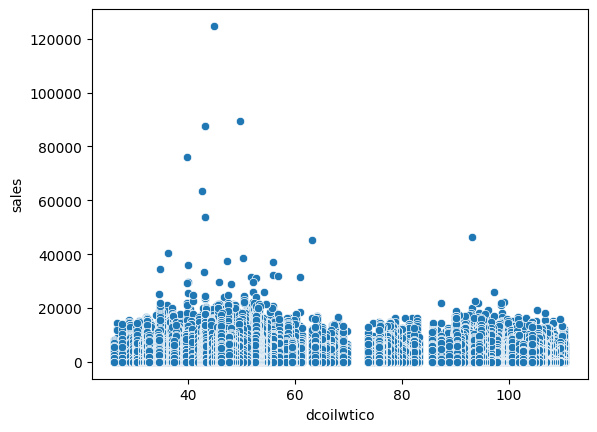

In [10]:
#Correlation between oil and sales
sns.scatterplot(data=df, x='dcoilwtico', y='sales')


<Axes: xlabel='date', ylabel='sales'>

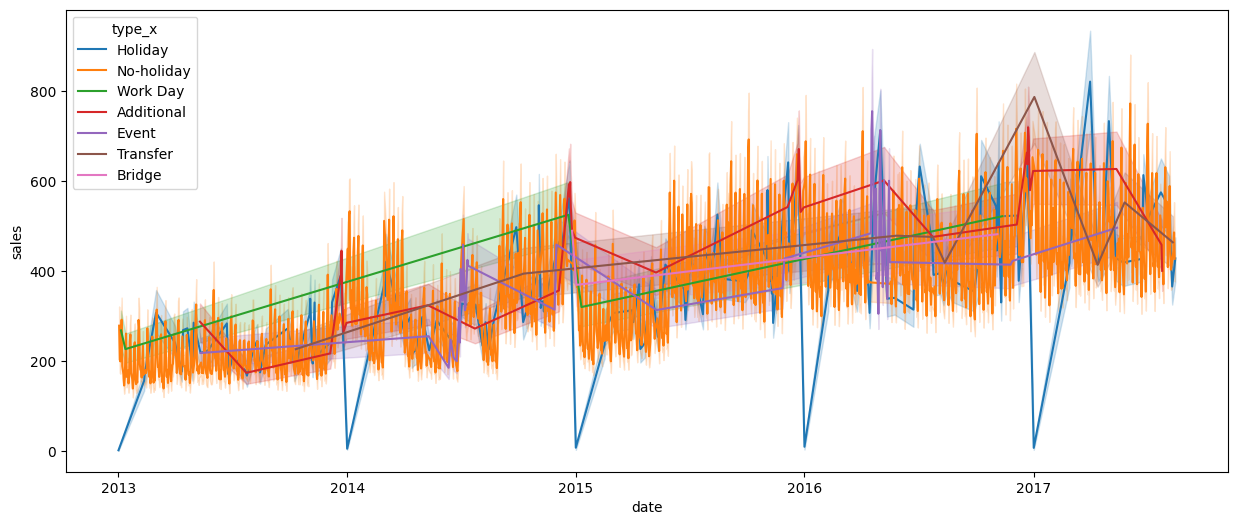

In [11]:
#Plot sales, date and 'type' of holiday
plt.figure(figsize=(15, 6))
sns.lineplot(data=df, x='date', y='sales', hue='type_x')

<Axes: xlabel='date', ylabel='sales'>

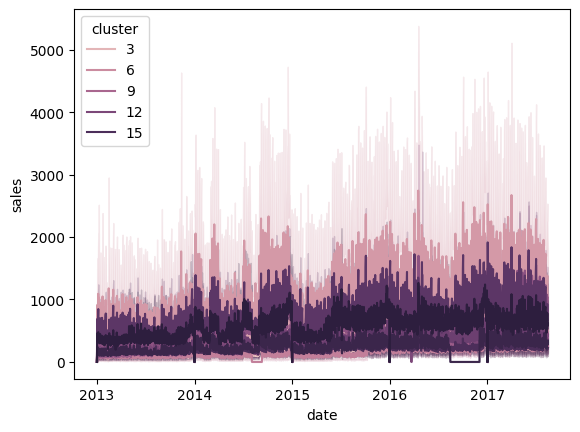

In [12]:
#Plot sales over time with cluster stores
sns.lineplot(data=df, x='date', y='sales', hue='cluster')

In [13]:
#Divide df into train and validation
train_size = int(len(df)*0.8)
df_80, df_20 = df[:train_size], df[train_size:]

<Axes: xlabel='date', ylabel='sales'>

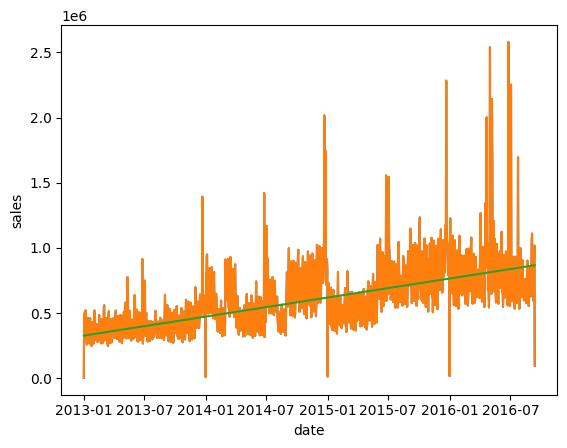

In [14]:
#Use linear regression to learn the trend
from sklearn.linear_model import LinearRegression
#Fit trend model
df_80_group = df_80.groupby('date').agg({'sales': 'sum'}).reset_index()
model_LR = LinearRegression()
model_LR.fit(df_80_group.index.values.reshape(-1, 1), df_80_group['sales'].values)
sns.lineplot(data=df_80_group, x='date', y='sales')
#Predict sales for df_80
df_80_group['trend'] = model_LR.predict(df_80_group.index.values.reshape(-1, 1))
#Plot sales with trend
sns.lineplot(data=df_80_group, x='date', y='sales')
sns.lineplot(data=df_80_group, x='date', y='trend')

<Axes: xlabel='date', ylabel='sales'>

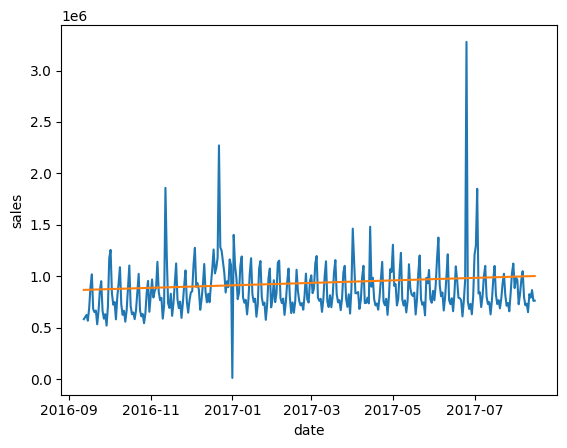

In [15]:
#Forecast df_20
df_20_group = df_20.groupby('date').agg({'sales': 'sum'}).reset_index()
df_20_group['trend'] = model_LR.predict(np.arange(len(df_80_group), len(df_80_group) + len(df_20_group)).reshape(-1, 1))
#Plot forecasted sales
sns.lineplot(data=df_20_group, x='date', y='sales')
#Plot forecasted sales with trend
sns.lineplot(data=df_20_group, x='date', y='trend')

<Axes: xlabel='date', ylabel='residuals'>

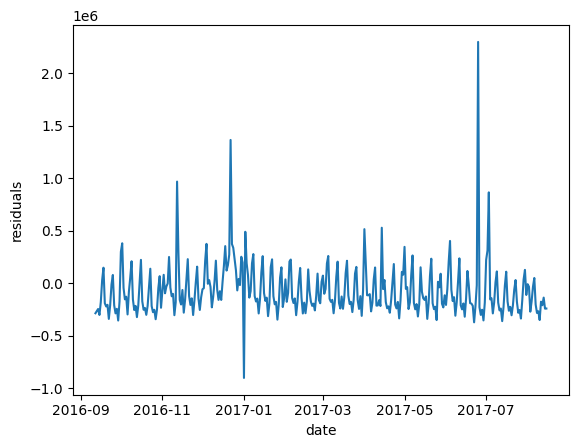

In [16]:
#Calculate residuals
df_20_group['residuals'] = df_20_group['sales'] - df_20_group['trend']
#Plot residuals
sns.lineplot(data=df_20_group, x='date', y='residuals')

In [17]:
#Initialize Y_train and X_train
Y_train = None
X_train = None
#Define Y as sales
Y_train = df_80['sales']
#Define X as all columns except 'sales'
X_train = df_80.drop(columns=['sales','id','store_nbr','onpromotion','city','state','type_y'])
#Separate date column in day, month and year
X_train['day'] = X_train['date'].dt.day
X_train['month'] = X_train['date'].dt.month
X_train['year'] = X_train['date'].dt.year
#Drop date column
X_train = X_train.drop(columns=['date'])
#Tranform object variables to categorical
for col in ['family', 'type_x', 'locale', 'transferred']:
    X_train[col] = X_train[col].astype('category')


In [18]:
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2443478 entries, 0 to 2443477
Data columns (total 9 columns):
 #   Column       Dtype   
---  ------       -----   
 0   family       category
 1   type_x       category
 2   locale       category
 3   transferred  category
 4   dcoilwtico   float64 
 5   cluster      int64   
 6   day          int32   
 7   month        int32   
 8   year         int32   
dtypes: category(4), float64(1), int32(3), int64(1)
memory usage: 74.6 MB
None


In [19]:
#Train XGBoost model
from xgboost import XGBRegressor
model_xgb = XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.1,enable_categorical=True)
model_xgb.fit(X_train, Y_train)
#Predict sales for df_20
X_test = df_20.drop(columns=['sales','id','store_nbr','onpromotion','city','state','type_y'])
#Separate date column in day, month and year
X_test['day'] = X_test['date'].dt.day
X_test['month'] = X_test['date'].dt.month
X_test['year'] = X_test['date'].dt.year
#Drop date column
X_test = X_test.drop(columns=['date'])
#Tranform object variables to categorical
for col in ['family', 'type_x', 'locale', 'transferred']:
    X_test[col] = X_test[col].astype('category')
#Predict sales
Y_pred = model_xgb.predict(X_test)
#Replace negative predictions with 0
Y_pred = np.where(Y_pred < 0, 0, Y_pred)


610870
610870


Text(0, 0.5, 'Predicted Sales')

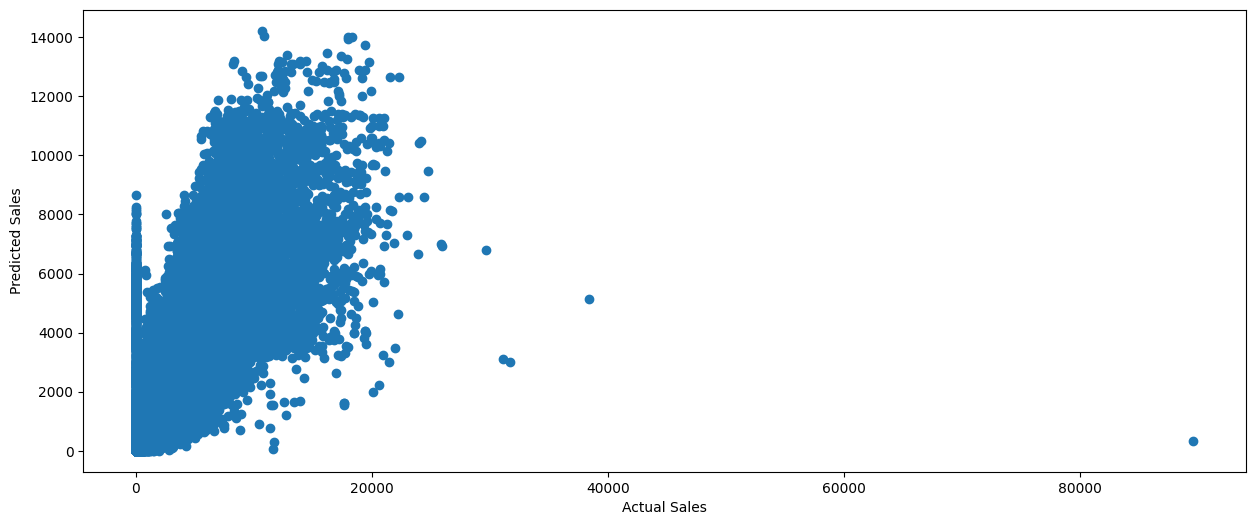

In [20]:
print(Y_pred.size)
print(df_20['sales'].size)
#Plot predicted sales vs actual sales
plt.figure(figsize=(15, 6))
plt.scatter(df_20['sales'], Y_pred)
#Show axes names
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')


In [21]:
df_20['sales_pred'] = Y_pred
#Residuals
df_20['residuals'] = df_20['sales'] - df_20['sales_pred']
print(df_20.head())

              id       date  store_nbr                   family    sales  \
2443478  2400710 2016-09-12         19             PET SUPPLIES    0.000   
2443479  2400711 2016-09-12         19  PLAYERS AND ELECTRONICS    4.000   
2443480  2400712 2016-09-12         19                  POULTRY   85.689   
2443481  2400713 2016-09-12         19           PREPARED FOODS   62.000   
2443482  2400714 2016-09-12         19                  PRODUCE  422.532   

         onpromotion      type_x      locale transferred  dcoilwtico  \
2443478            0  No-holiday  No-holiday  No-holiday       46.28   
2443479            0  No-holiday  No-holiday  No-holiday       46.28   
2443480            0  No-holiday  No-holiday  No-holiday       46.28   
2443481            1  No-holiday  No-holiday  No-holiday       46.28   
2443482            1  No-holiday  No-holiday  No-holiday       46.28   

             city    state type_y  cluster  sales_pred  residuals  
2443478  Guaranda  Bolivar      C       15

C:\Users\75558\AppData\Local\Temp\ipykernel_14592\3495214740.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_20['sales_pred'] = Y_pred
C:\Users\75558\AppData\Local\Temp\ipykernel_14592\3495214740.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_20['residuals'] = df_20['sales'] - df_20['sales_pred']


Text(0.5, 1.0, 'Residuals for family: BABY CARE before 2019-01-01')

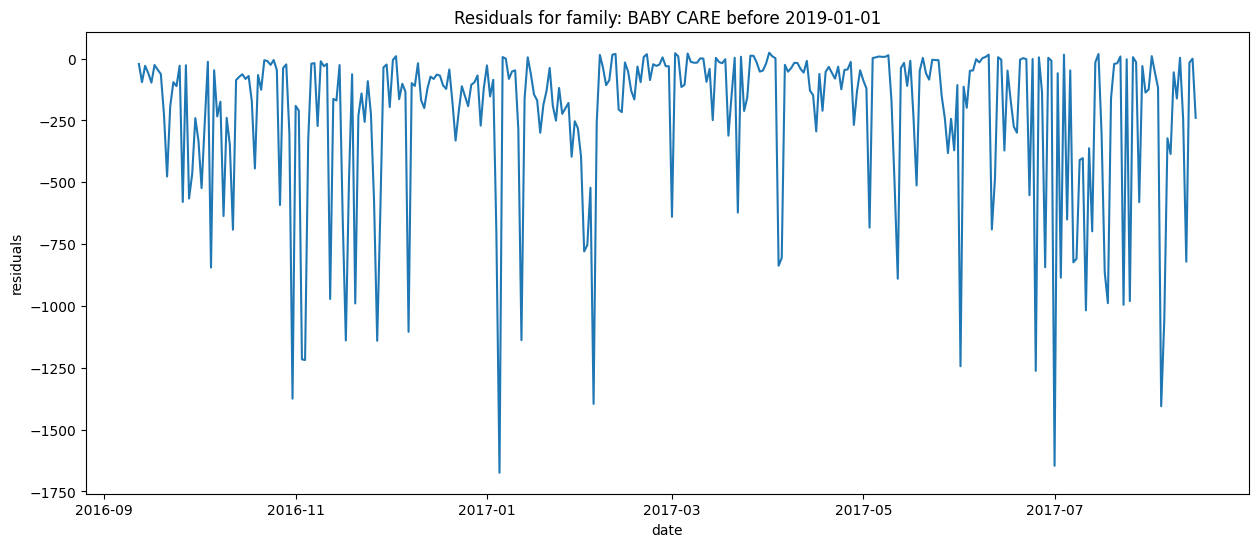

In [22]:
#Time series by family with residuals
#Group by date and family, sum residuals
df_family_20 = None
df_family_20 = df_20.groupby(['date', 'family']).agg({'residuals': 'sum'}).reset_index()
#Filter df_family_20 for 'family' = '' for dates < 
family_list = df_family_20['family'].unique()
fam=family_list[1]
dates= '2019-01-01'
df_family_20_filtered = df_family_20[(df_family_20['family'] == fam) & (df_family_20['date'] < dates)]
#Plot sales for '' family
plt.figure(figsize=(15, 6))
sns.lineplot(data=df_family_20_filtered, x='date', y='residuals')
#Title family
plt.title(f'Residuals for family: {fam} before {dates}')


<Axes: xlabel='date', ylabel='sales'>

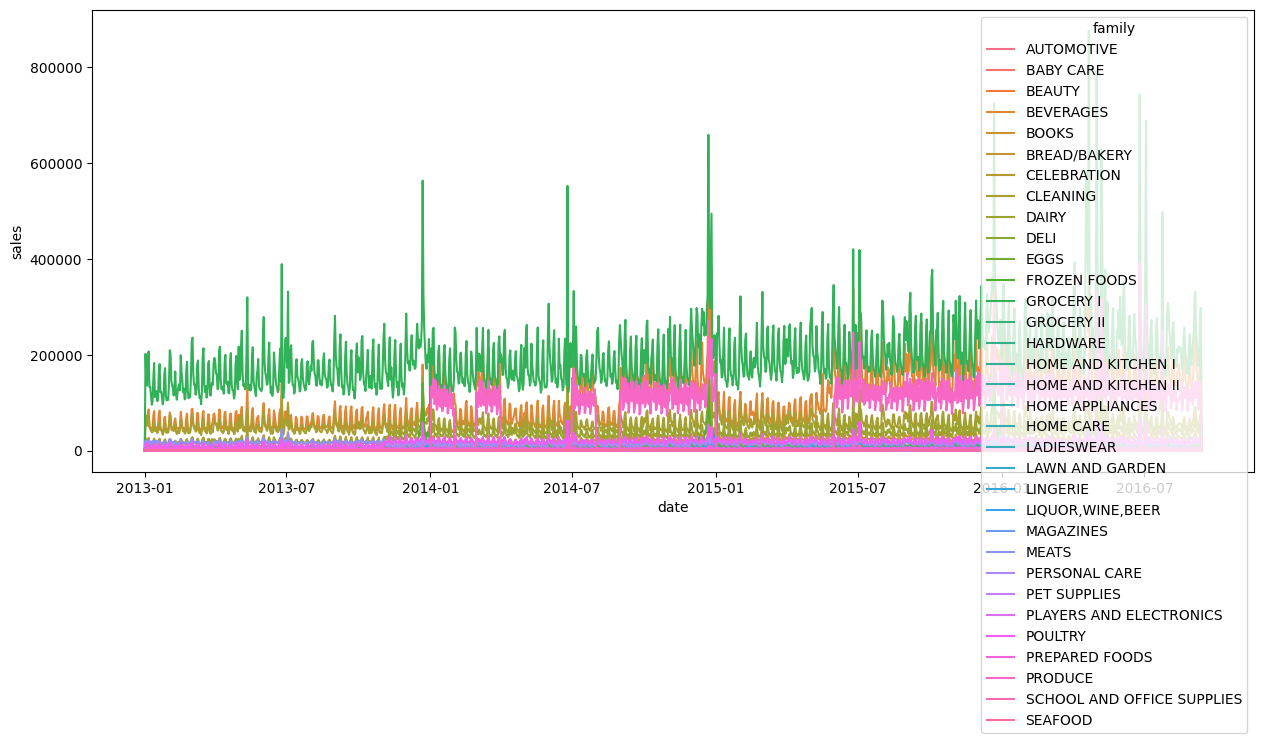

In [23]:
#Time series by family
df_family_80 = df_80.groupby(['date', 'family']).agg({'sales': 'sum'}).reset_index()
#Plot sales by family
plt.figure(figsize=(15, 6))
sns.lineplot(data=df_family_80, x='date', y='sales', hue='family')

Text(0.5, 1.0, 'Sales for family: BABY CARE before 2019-01-01')

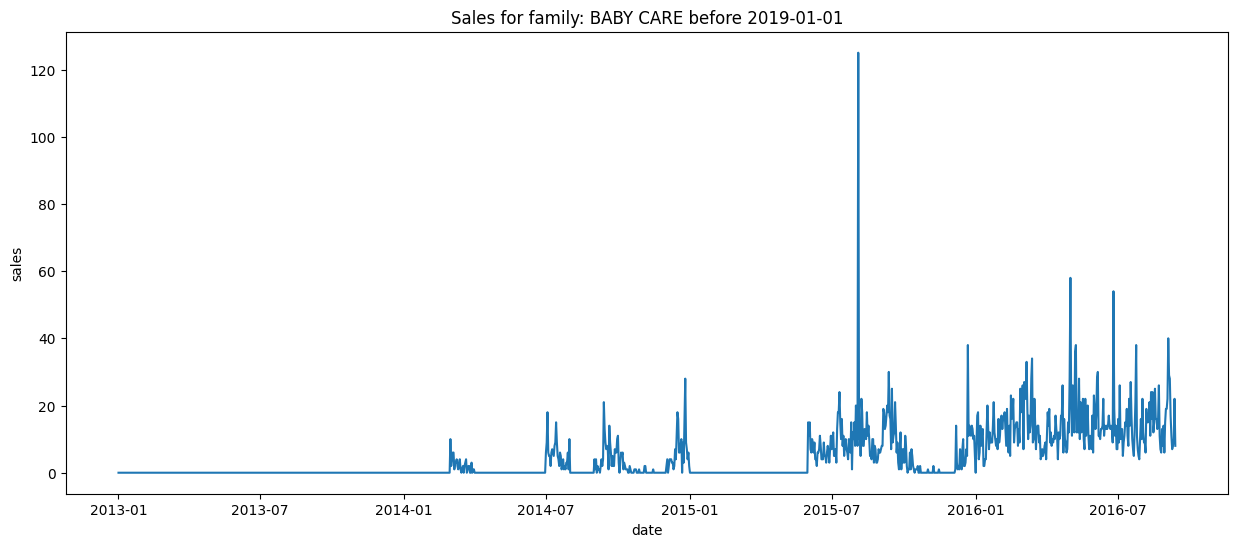

In [24]:
#Filter df_family_80 for 'family' = '' for dates < 
family_list = df_family_80['family'].unique()
fam=family_list[1]
dates= '2019-01-01'
df_family_80_filtered = df_family_80[(df_family_80['family'] == fam) & (df_family_80['date'] < dates)]
#Plot sales for '' family
plt.figure(figsize=(15, 6))
sns.lineplot(data=df_family_80_filtered, x='date', y='sales')
#Title family
plt.title(f'Sales for family: {fam} before {dates}')



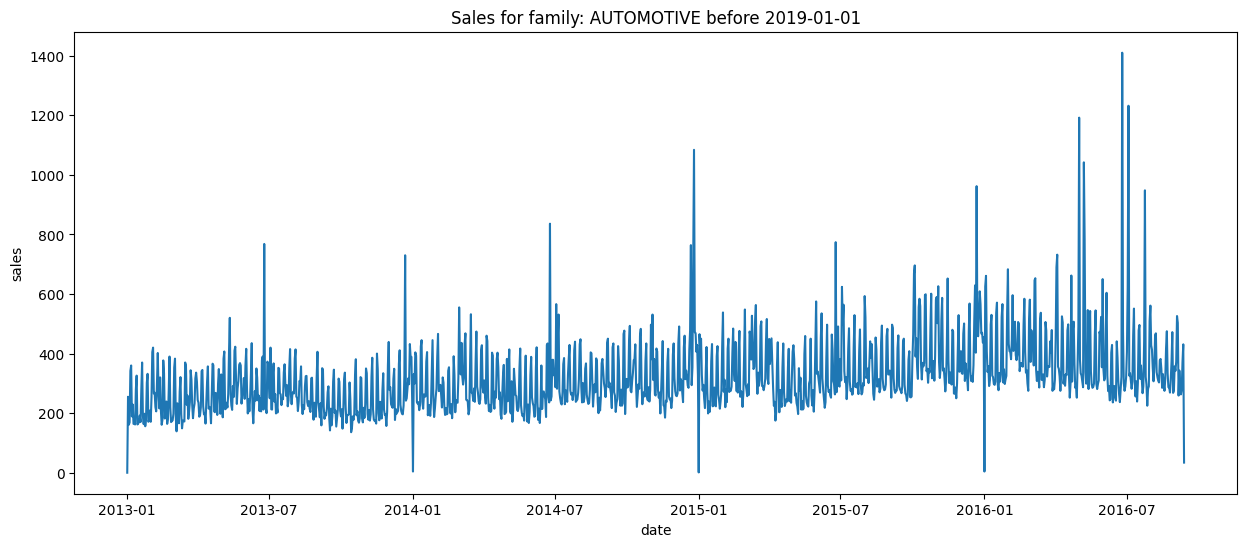

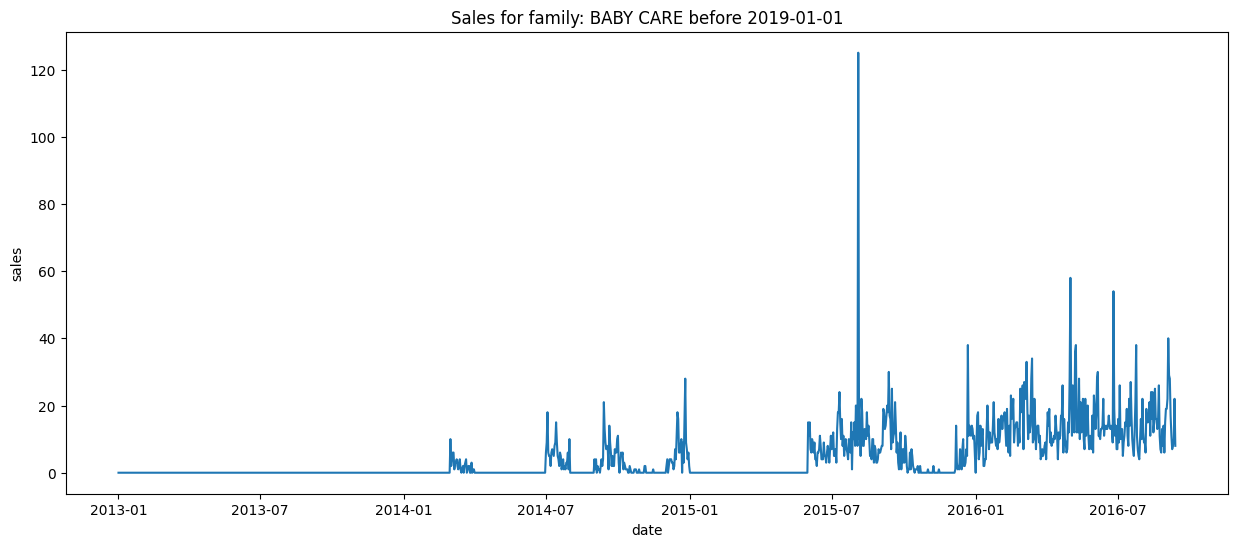

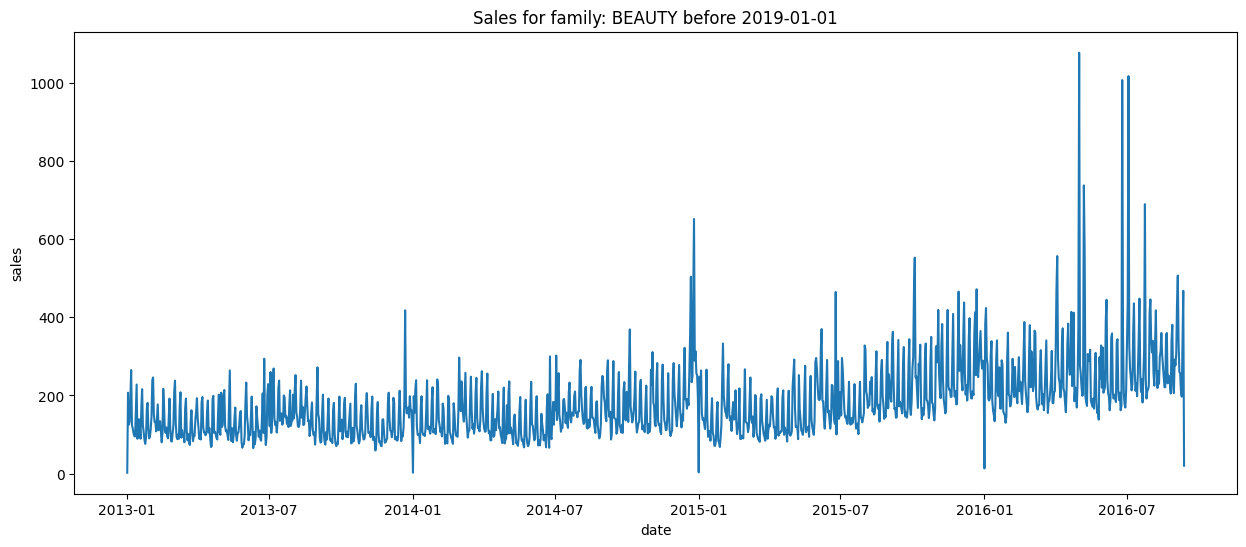

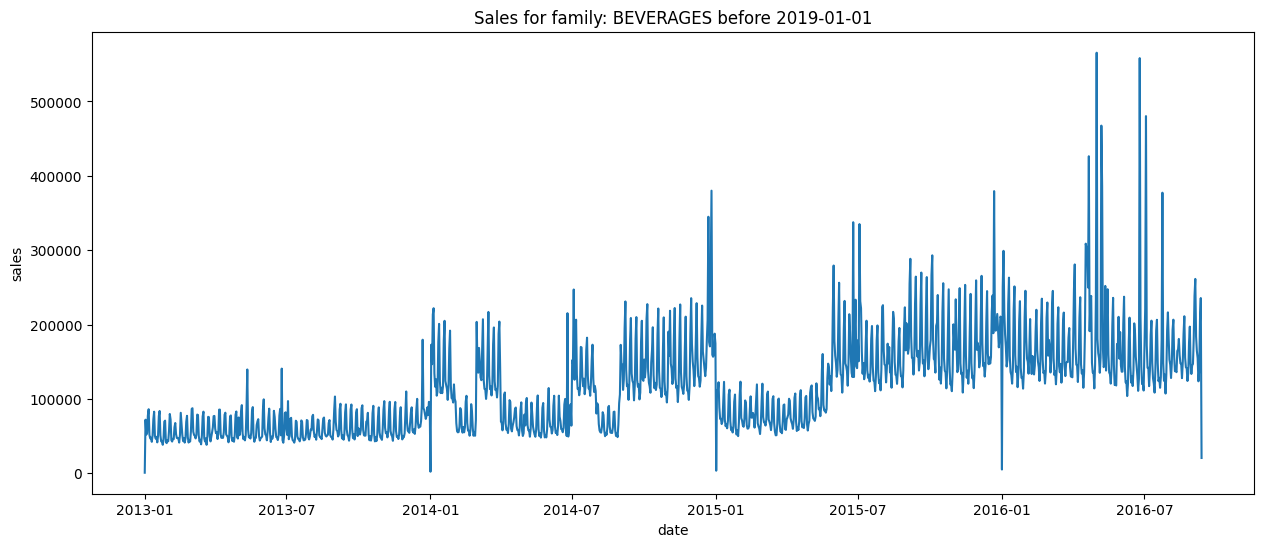

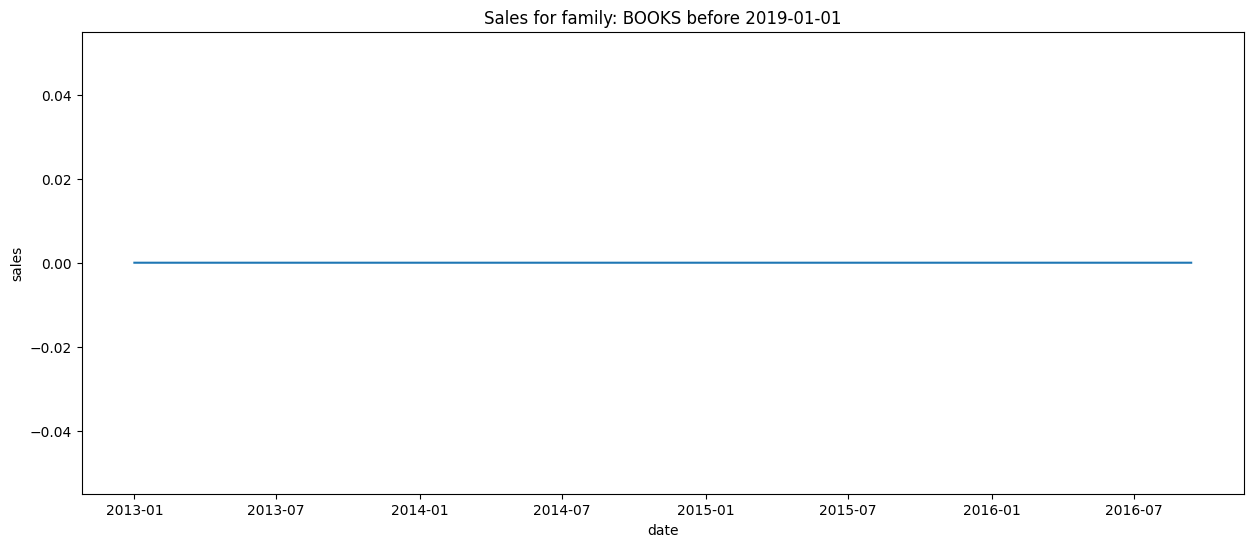

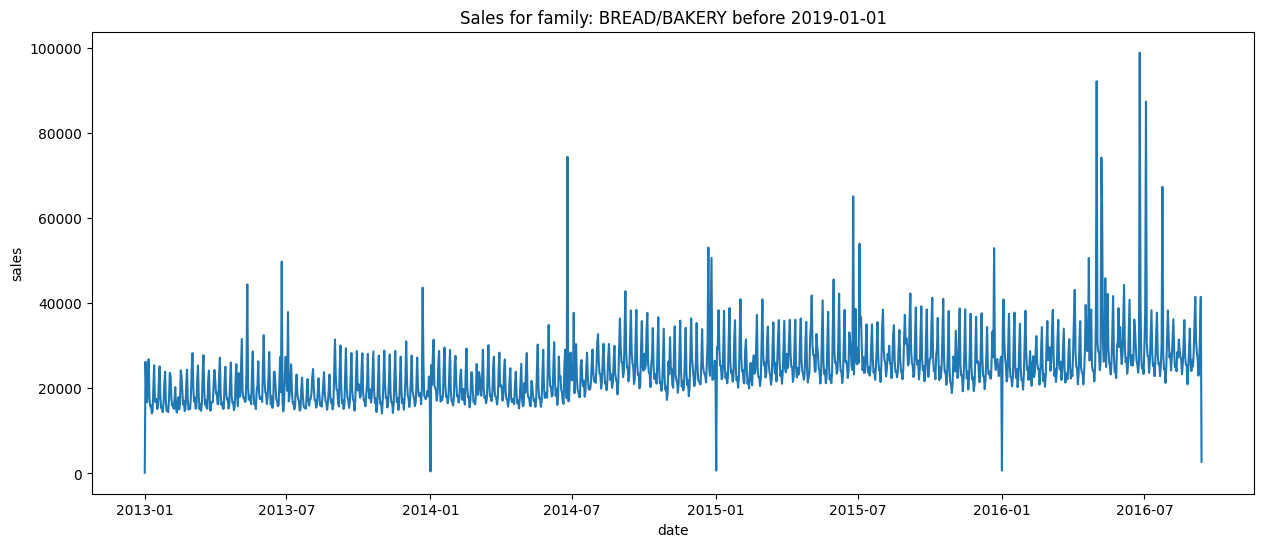

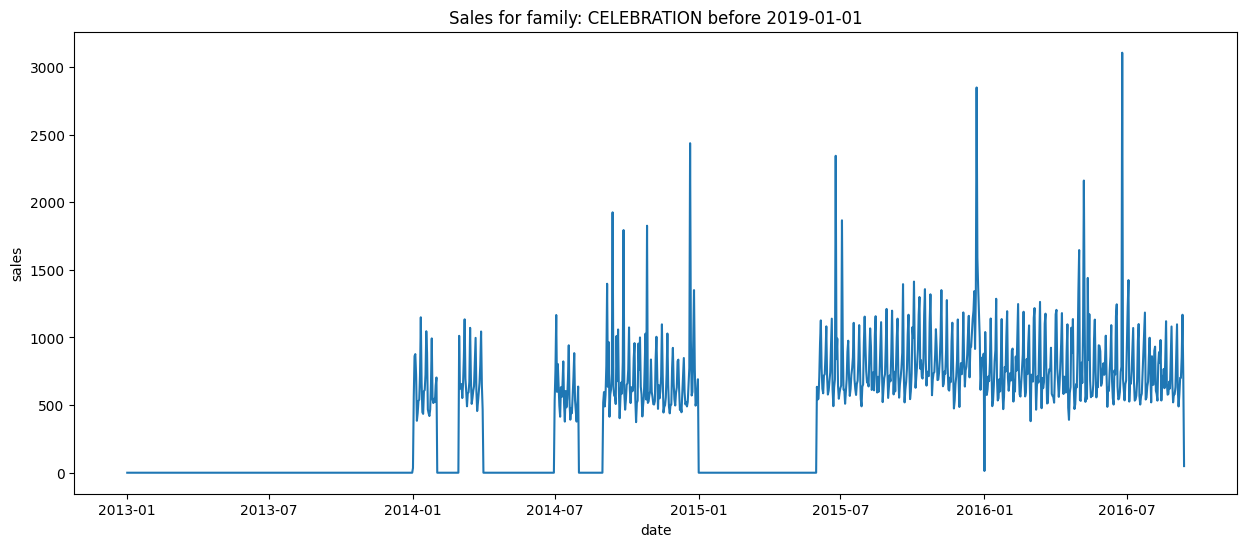

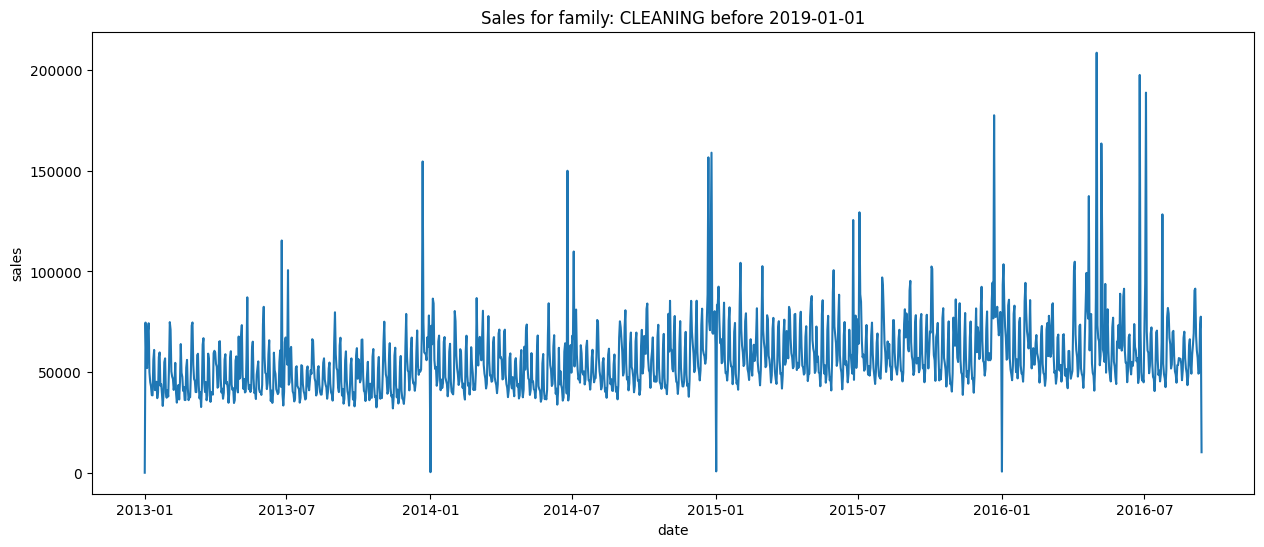

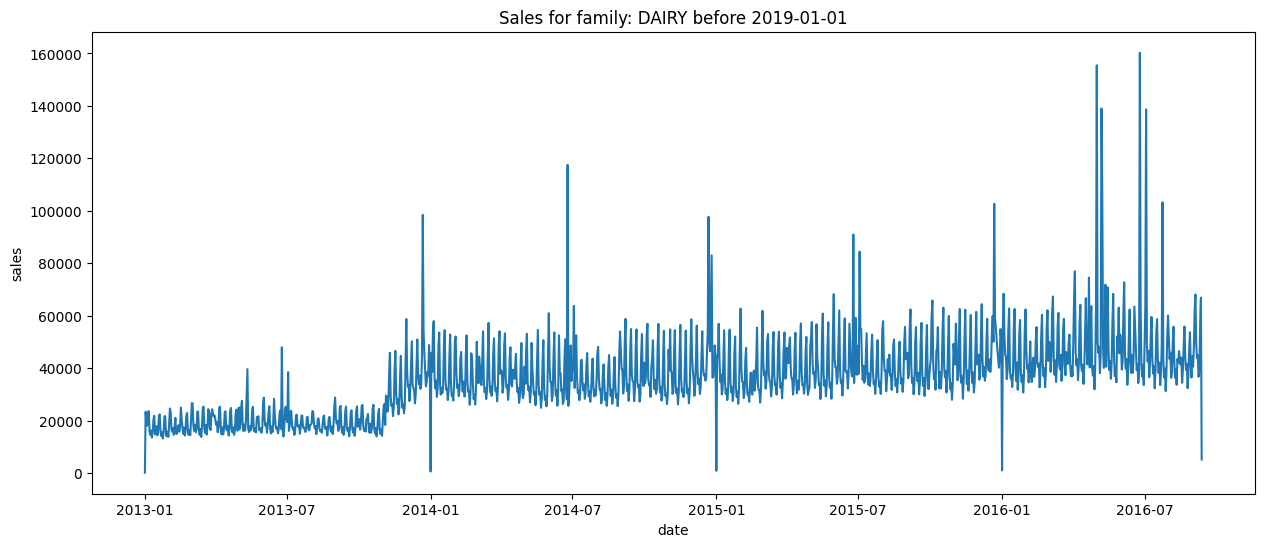

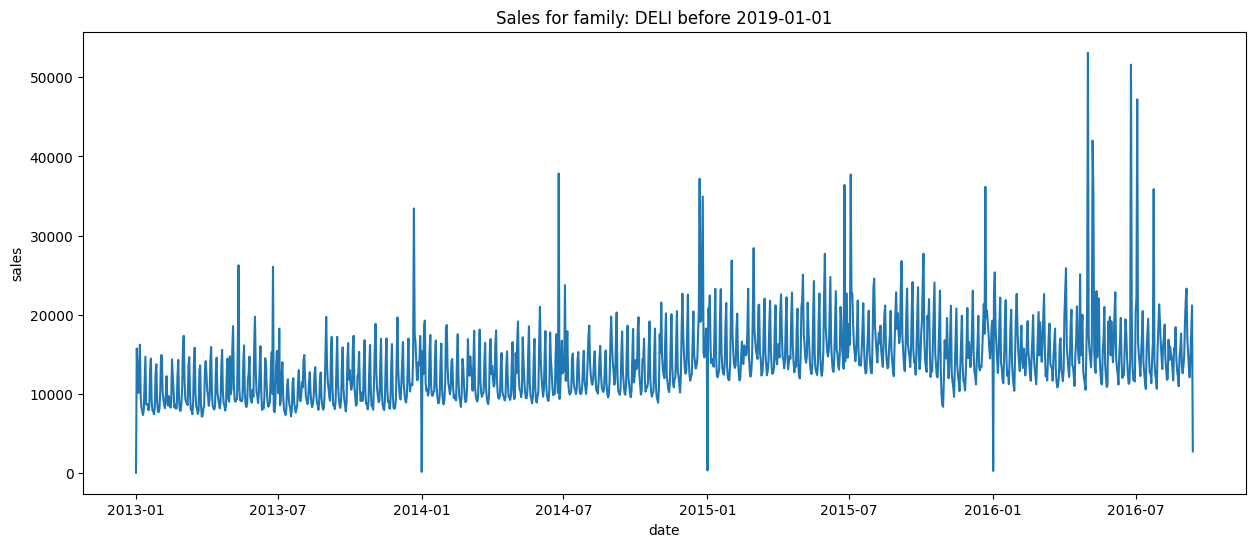

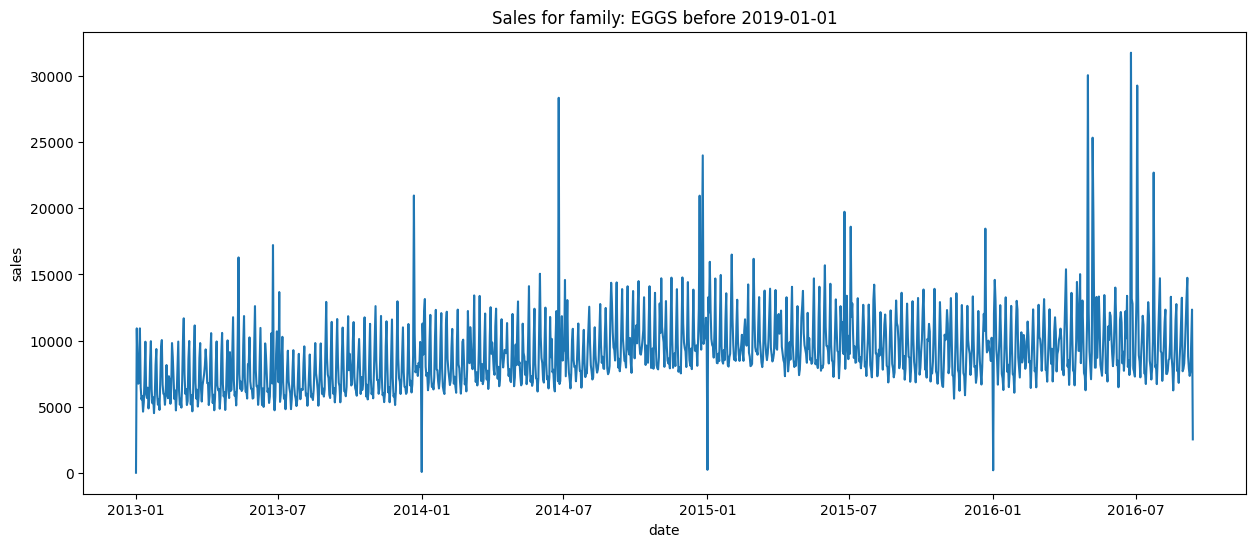

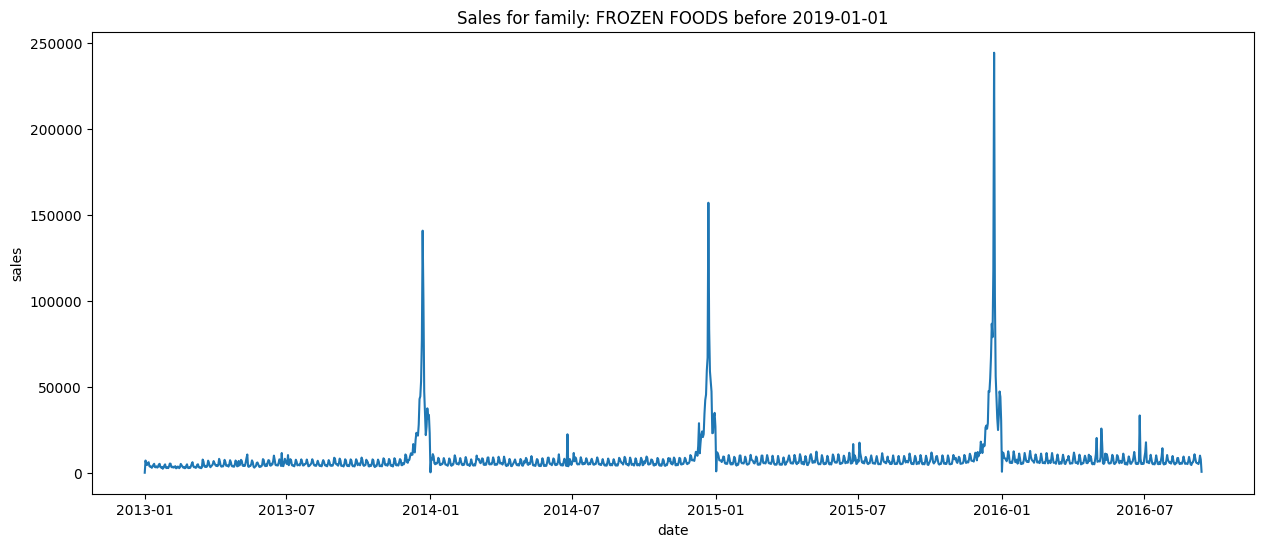

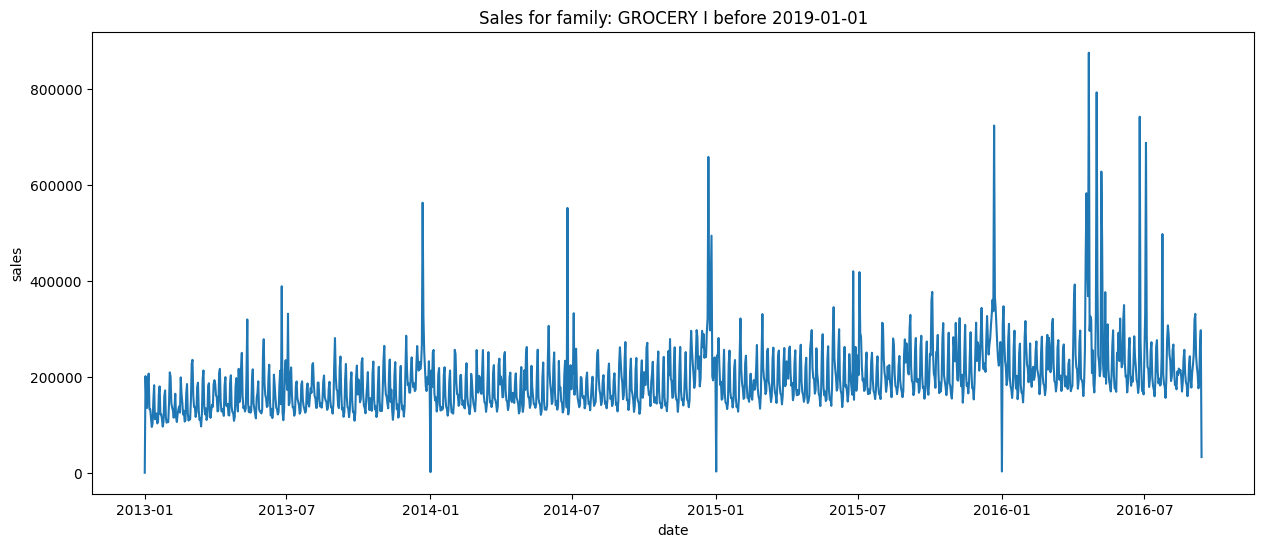

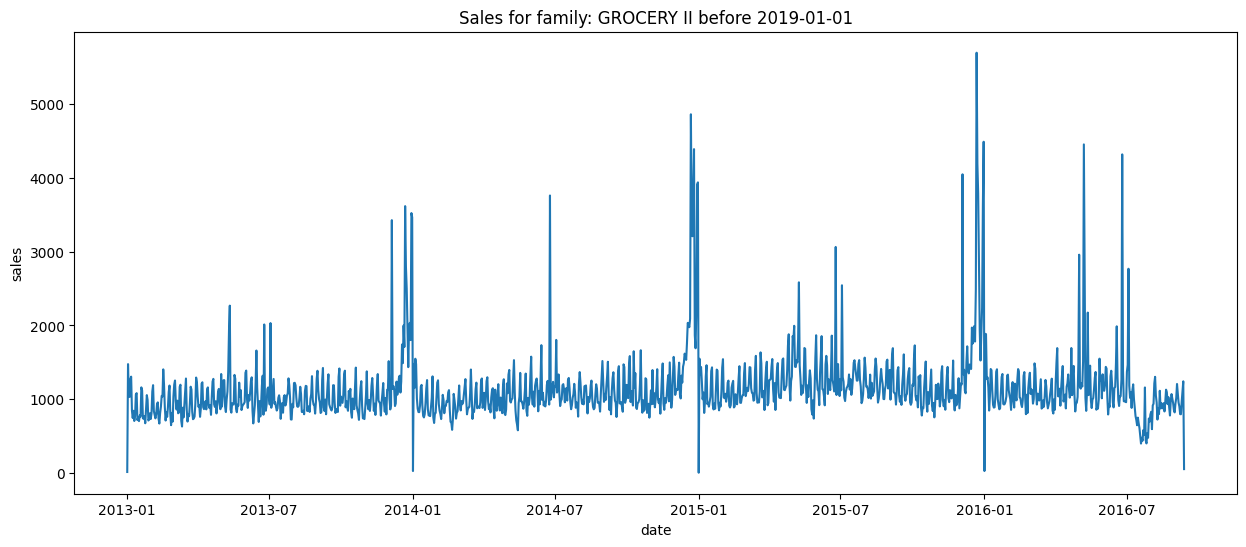

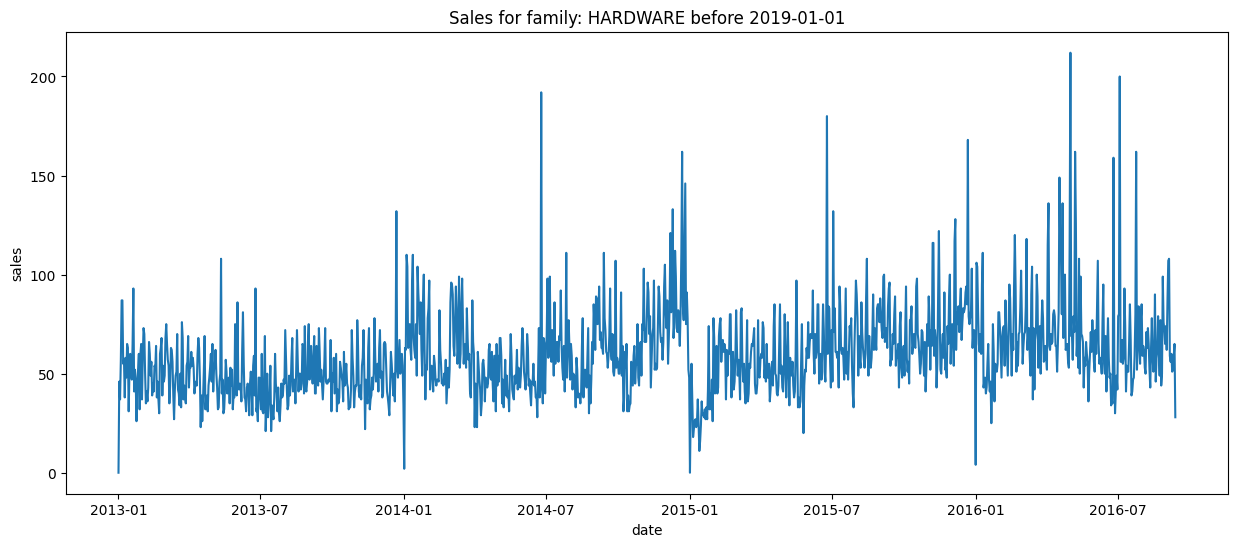

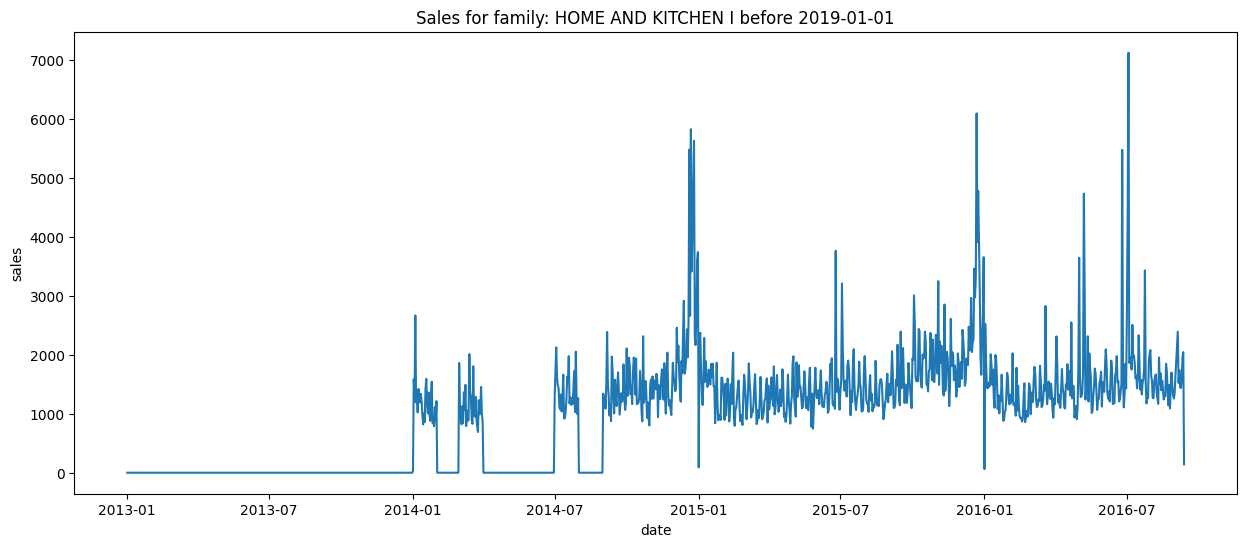

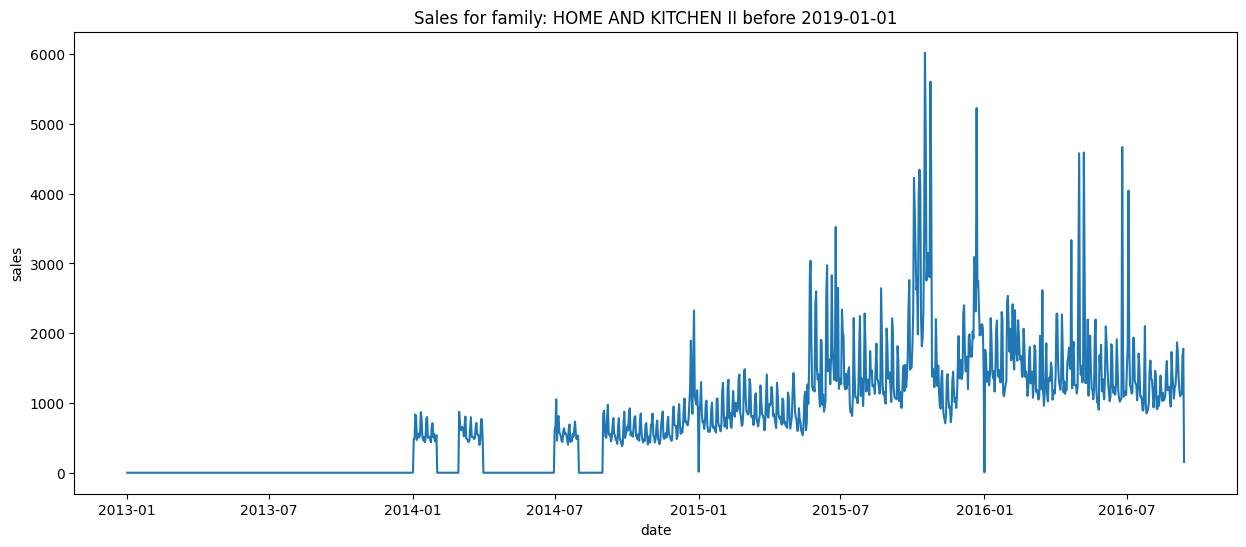

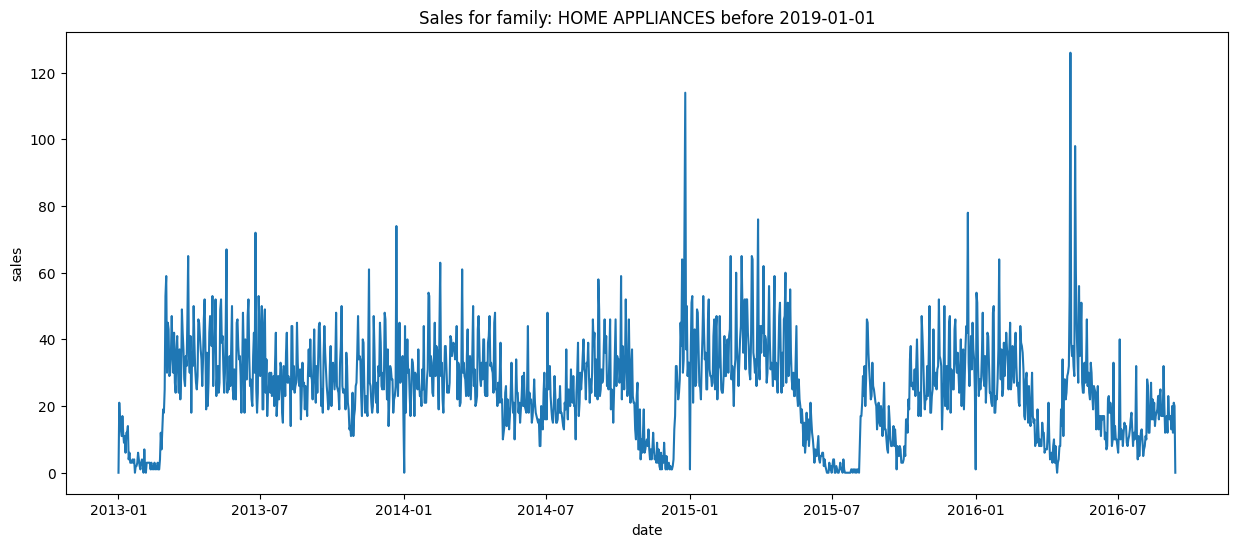

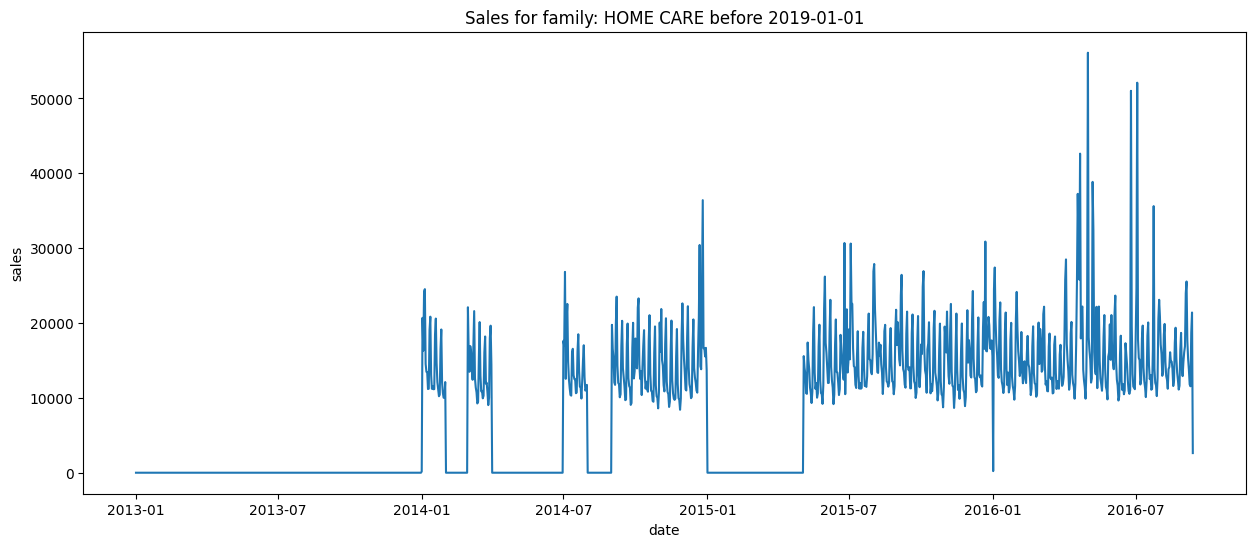

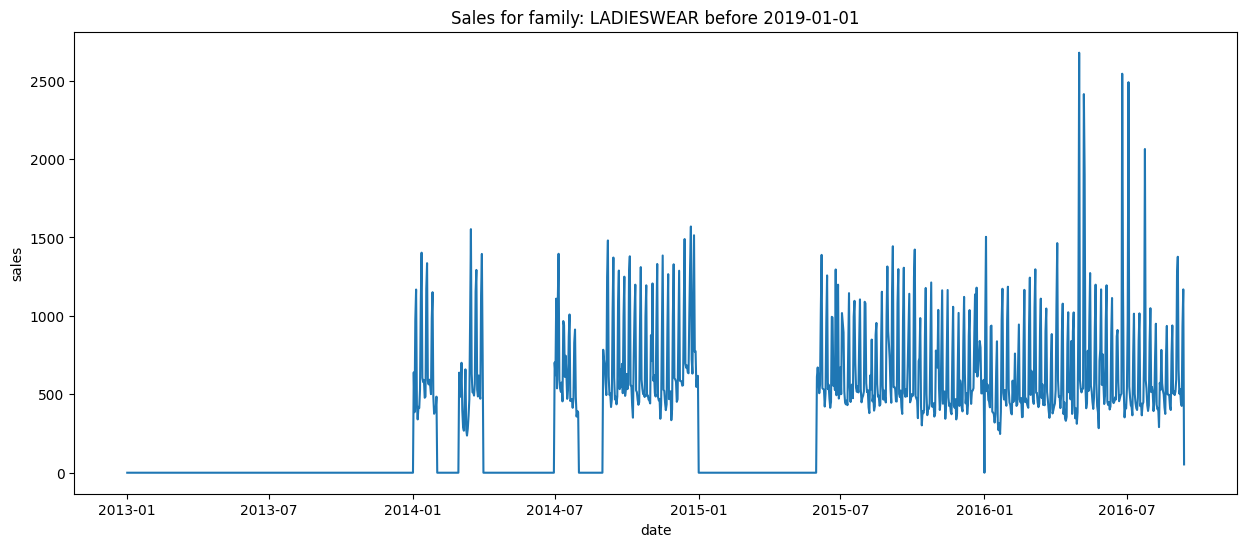

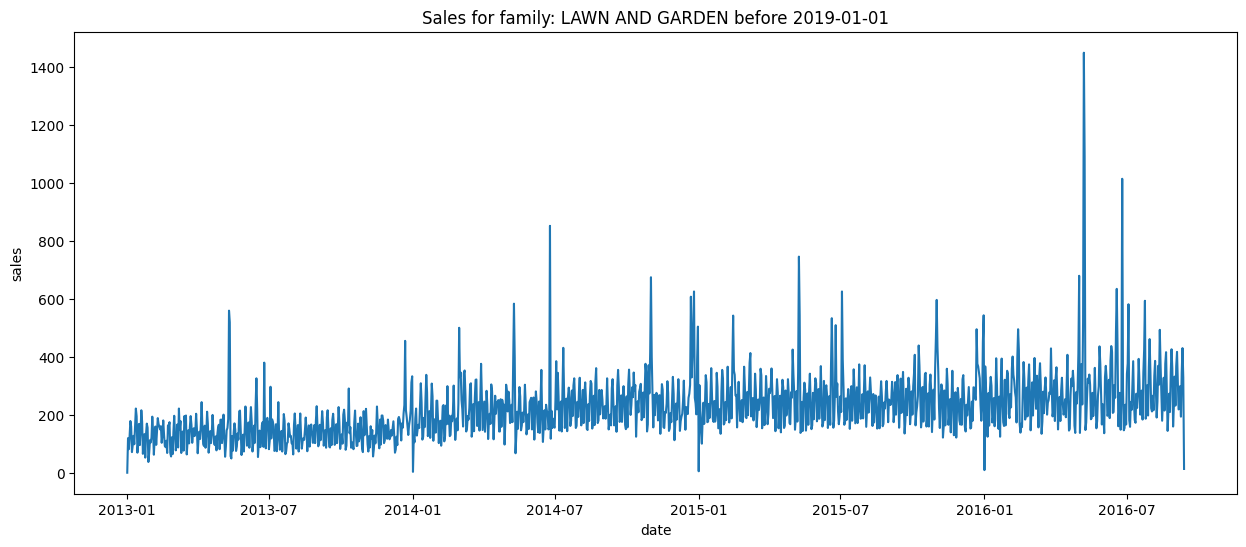

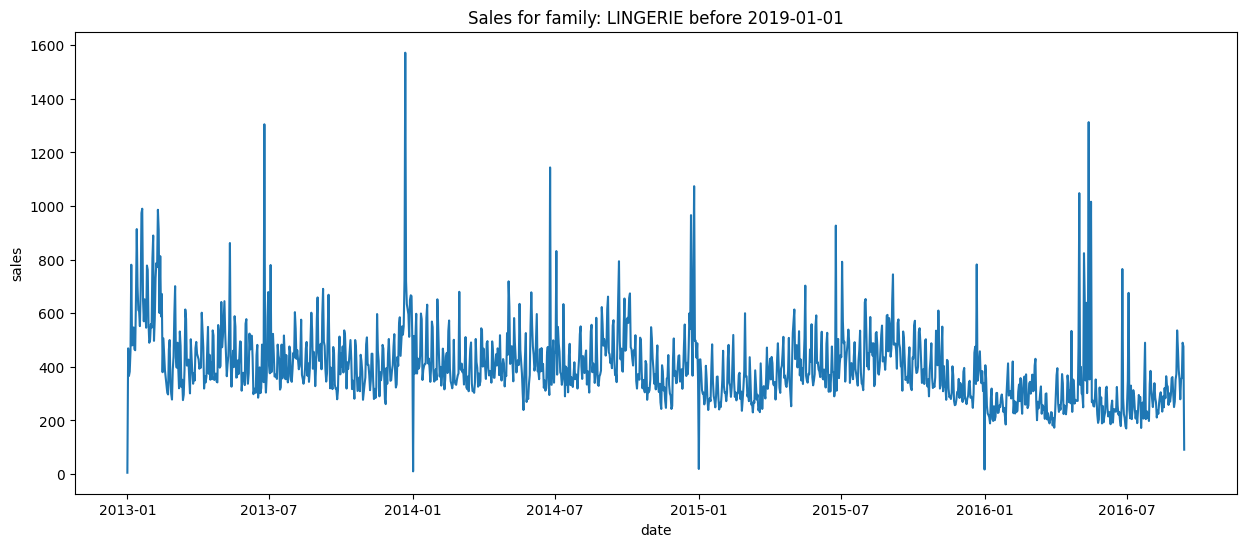

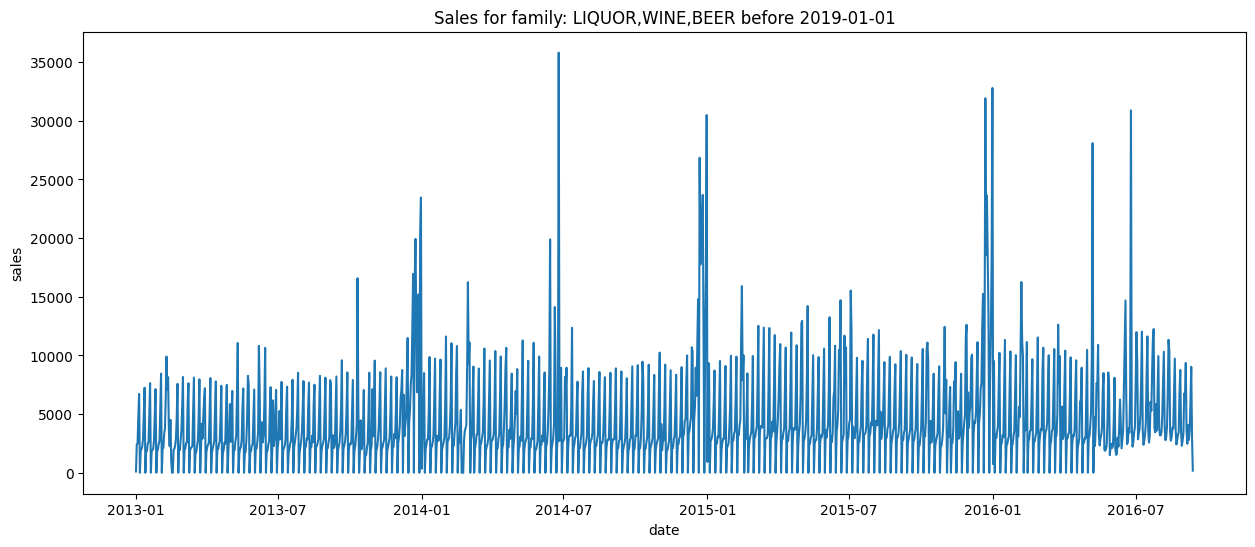

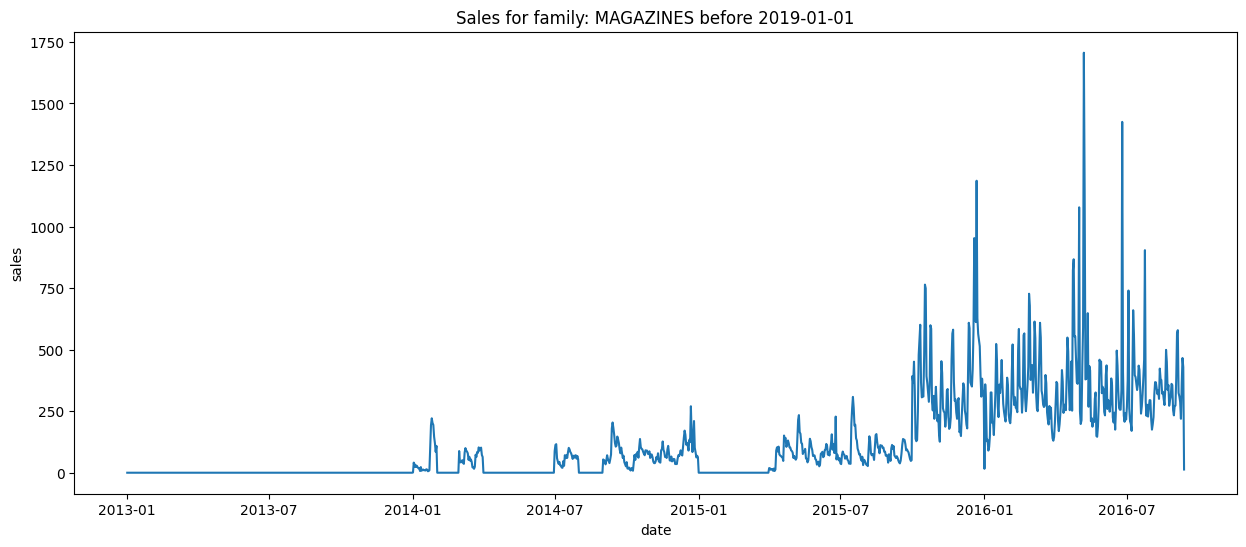

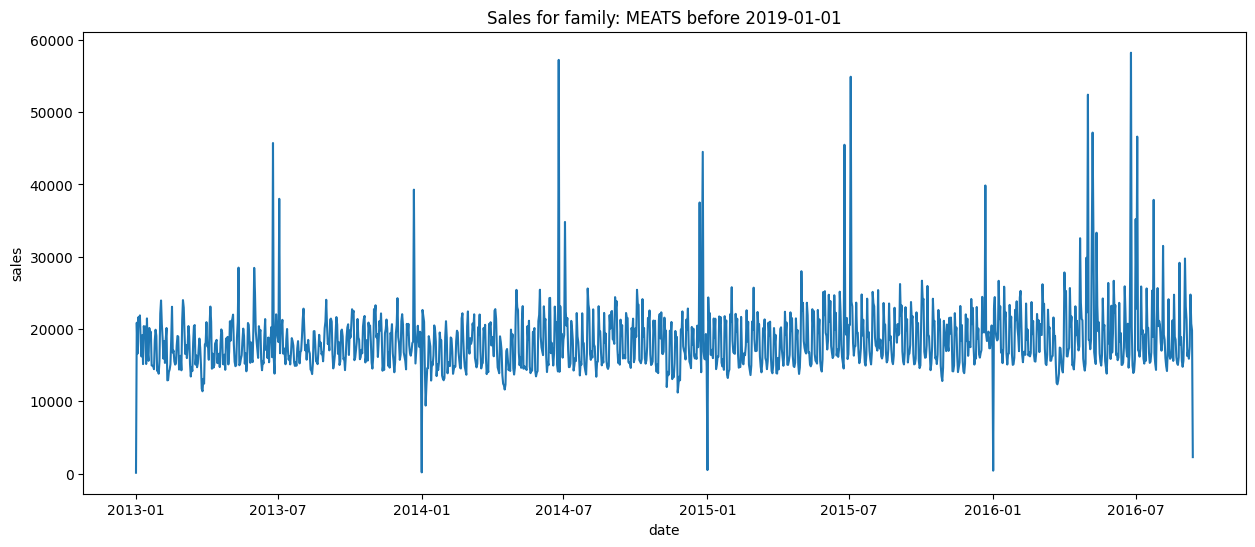

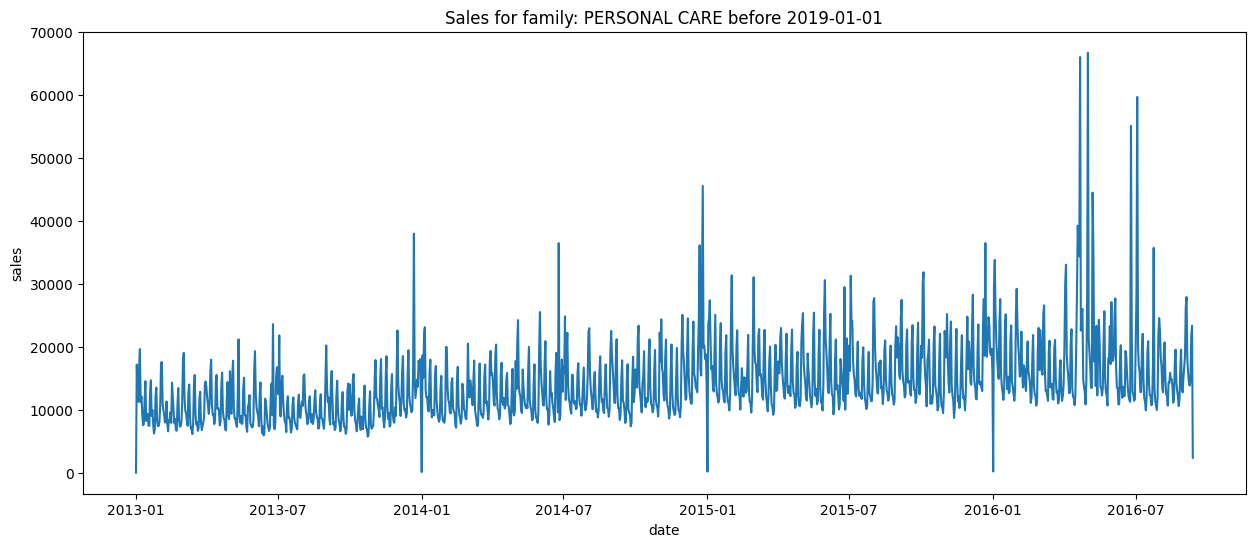

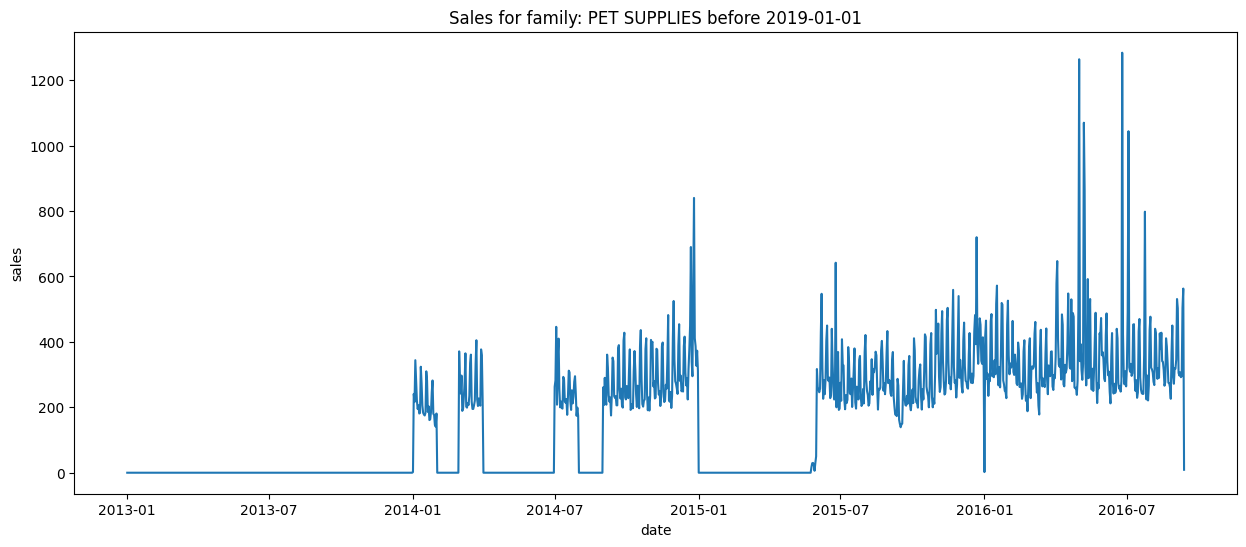

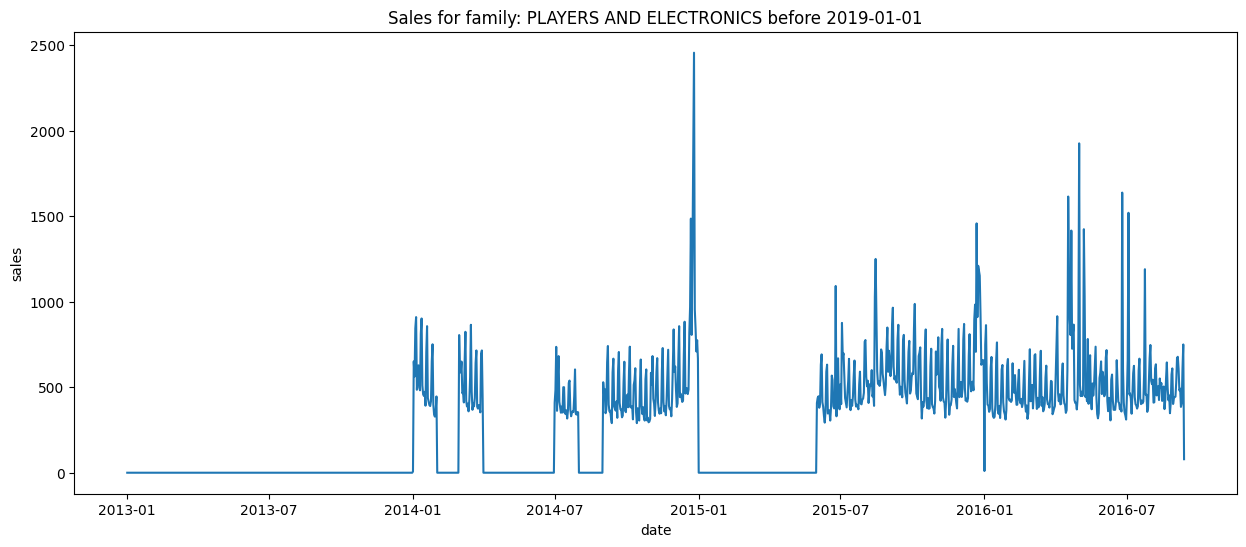

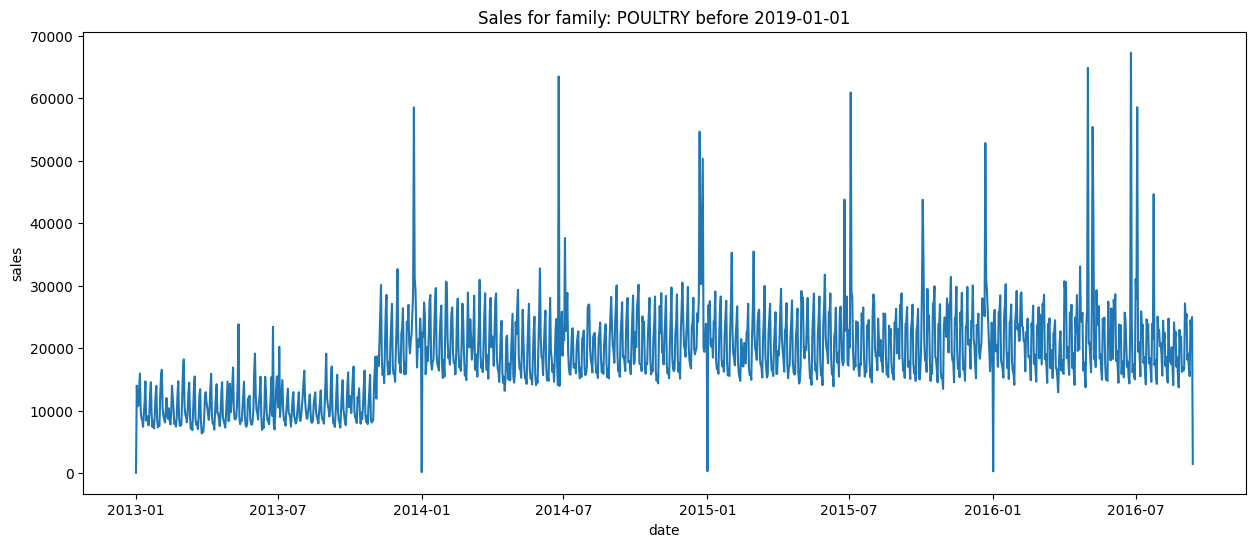

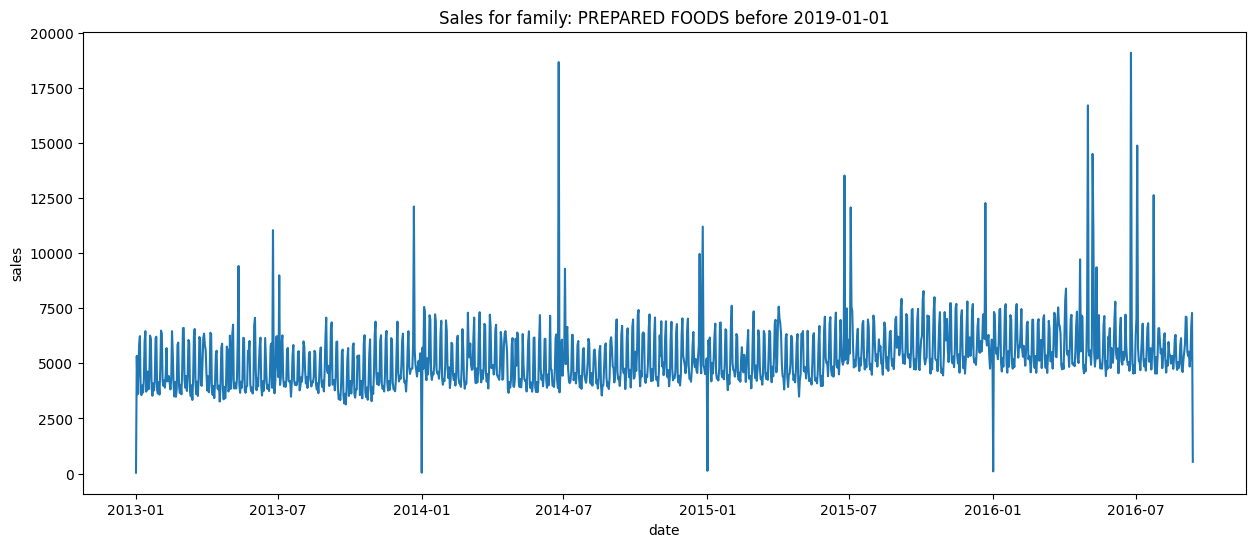

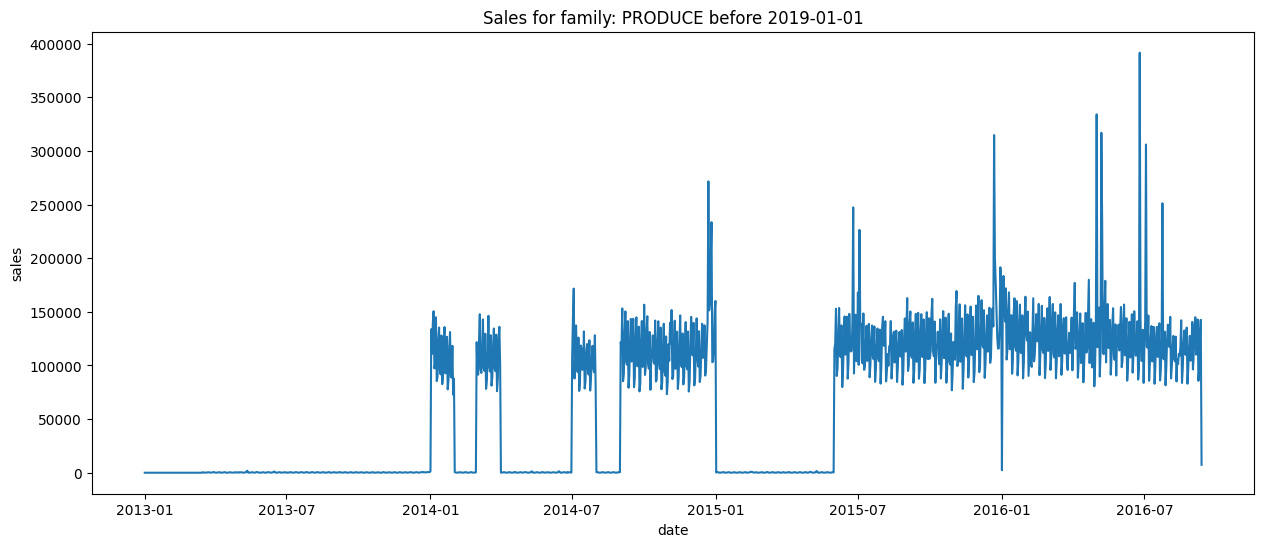

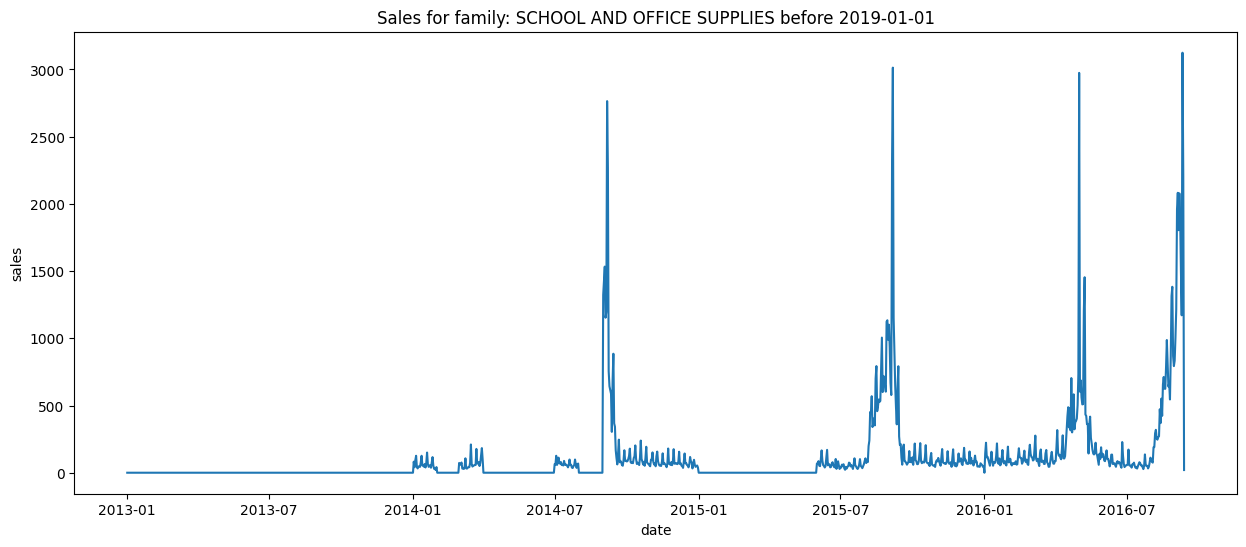

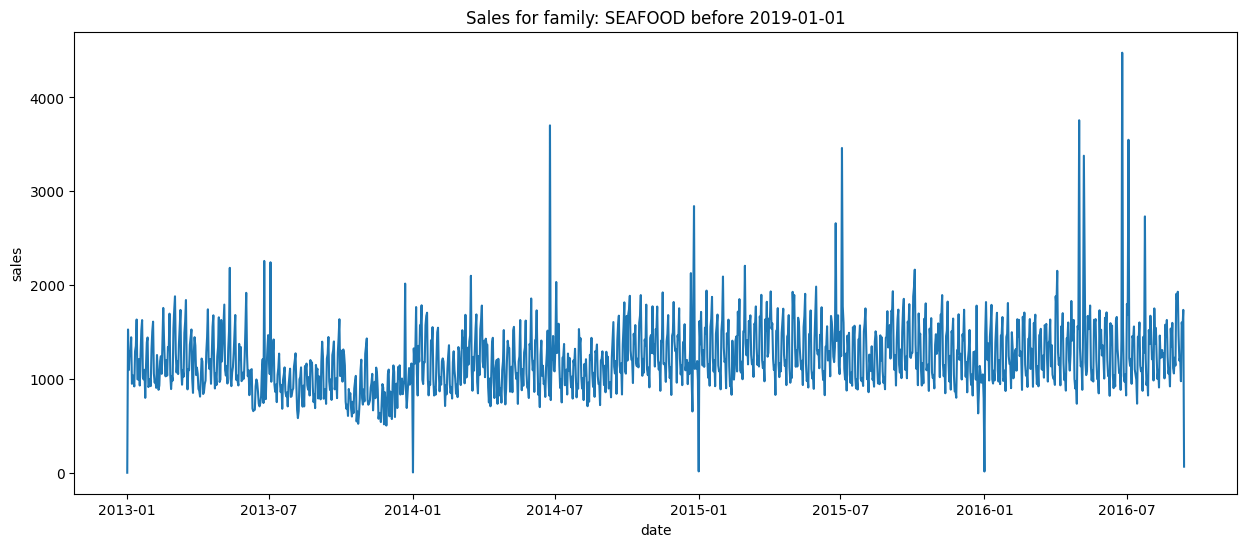

In [25]:
#Plot all families sales
for fam in family_list:
    df_family_80_filtered = df_family_80[(df_family_80['family'] == fam) & (df_family_80['date'] < dates)]
    plt.figure(figsize=(15, 6))
    sns.lineplot(data=df_family_80_filtered, x='date', y='sales')
    plt.title(f'Sales for family: {fam} before {dates}')
    plt.show()